In [71]:
import requests
import json
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from ggplot import *

## Project details

For the project I'm intending to pull trade date for Elite: Dangerous from EDDB (Elite Dangerous DataBase). EDDB is a third party tool, relying on user submitted data, as well as scraping the official netlogs, and the API for a defunct iOS app. It also shares data with multiple other tools and databases intended for Elite: Dangerous players. Based on my current searches, it seems like the developers of Elite: Dangerous (sometimes also called Adjective: Adjective), Frontier Developments plc do not have a convenient public API.

I'm largely analysing this data to satisfy my own idle curiosity--While I do play the game, I mostly play as a pirate, rather than a trader. It could still be interesting and useful in determining what salvage is worthwhile, or in picking trade lanes to target, but mostly I'm just curious.

###### Possible Project Questions:
1. What is the ranking in terms of average price across commodity categories?
6. Is there a significant differece in price between rare and non-rare sub-categories within a given commodity category?
2. What ten non-rare commodities have the highest profit margin?
3. What ten rare commodities have the lowest profit margin?
4. Do rare commodities always have a higher or lower profit margin than non-rare ones?

Note: One of the somewhat awkward commodity categories is Slavery. Apparently, it's impossible to create a sci-fi setting featuring an empire without also having that empire allow slavery. Then again, one doesn't exactly play Adjective: Adjective for its *creative* setting.

### Datasets:

#### Commodity Reference dataset from EDDB

This dataset represents aggregated commodity data across individual commodities and in-game locations. It does not include information about commodity prices at different locations within the game, but rather represents average prices across the game's galaxy.

In [53]:
comreq = requests.get("https://eddb.io/archive/v4/commodities.json")

In [54]:
commodities = json.loads(comreq.text)
com_data = pd.DataFrame(commodities)

In [55]:
def extract_category_name(category_dict):
    category_name = category_dict['name']
    return category_name

def extract_category_wrapper(a_row):
    return extract_category_name(a_row.category)

In [56]:
temp_com_data = com_data
temp_com_data['category'] = temp_com_data.apply(extract_category_wrapper, axis=1)
com_data = temp_com_data

In [127]:
com_data.rename(columns={'id': 'commodity_id'}, inplace=True)
com_data.head()

,average_price,category,category_id,commodity_id,is_rare,name
0,261,Chemicals,1,1,0,Explosives
1,110,Chemicals,1,2,0,Hydrogen Fuel
2,181,Chemicals,1,3,0,Mineral Oil
3,241,Chemicals,1,4,0,Pesticides
4,285,Consumer Items,2,5,0,Clothing


#### Price Listings dataset from EDDB

This dataset is the raw data on commodity prices throughout the game's galaxy. It contains entries for the buy and sell prices, demand, etc. for individual commodities across multiple stations. This also includes an identifier for the station that the individual entry was sourced from.

In [58]:
pricereq = requests.get("https://eddb.io/archive/v4/listings.csv")
price_row_list = pricereq.text.split('\n')

In [59]:
price_headings = price_row_list[0]
price_row_list = price_row_list[1:]

In [60]:
price_headings = price_headings.split(",")

In [61]:
for index in range(len(price_row_list)):
    entry_str = price_row_list[index]
    new_entry = entry_str.split(",")
    price_row_list[index] = new_entry

In [62]:
x = len(price_headings)
problem_indices = []
for entry in price_row_list:
    if len(entry) != x:
        index = price_row_list.index(entry)
        problem_indices.append(index)
        
for index in problem_indices:
    del price_row_list[index]

In [63]:
prices = {}
for index in range(len(price_headings)):
    key = price_headings[index]
    value = []
    for entry in price_row_list:
        value.append(int(entry[index]))
    prices[key] = value
    
price_data = pd.DataFrame(prices)

In [128]:
price_data.head(10)

,buy_price,collected_at,commodity_id,demand,id,sell_price,station_id,supply
0,0,1475765153,5,103,1,315,1,0
1,0,1475765153,6,8,2,6795,1,0
2,0,1475765153,7,63,3,527,1,0
3,0,1475765153,14,14,4,1286,1,0
4,0,1475765153,15,33,5,1286,1,0
5,0,1475765153,16,51,6,403,1,0
6,0,1475765153,17,4,7,203,1,0
7,0,1475765153,18,105,8,315,1,0
8,0,1475765153,19,89,9,207,1,0
9,0,1475765153,20,9,10,319,1,0


### Data Analysis:

#### What is the average commodity price within every category? e.g. what are the average price of Chemicals or Consumer Items? Additionally, what categories have the highest average price?

In [86]:
cat_avg = com_data.groupby('category').mean().sort_values('average_price', ascending=False)[['average_price']]
cat_avg = cat_avg.reset_index()
cat_avg

,category,average_price
0,Salvage,34375.025000
1,Slavery,15719.333333
2,Industrial Materials,11845.900000
3,Consumer Items,9443.642857
4,Minerals,9363.045455
5,Metals,9222.086957
6,Weapons,8286.700000
7,Legal Drugs,8146.333333
8,Medicines,7661.588235
9,Foods,7412.122449


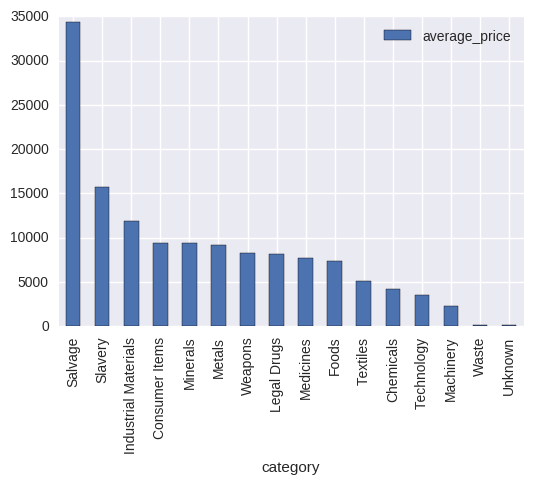

In [104]:
cat_avg.plot(x='category', y='average_price', kind='bar')

Here, it seems like several categories I wouldn't have expeted to be quite as valuable rank very highly in terms of average price. Salvage or Consumer items are commodity categories I would have expected to have a fairly low value, but instead rank quite highly. I'm now curious as to to if rare items within a given category are driving the average price for the whole category up significantly.

#### What are the seperate average prices of rare and non-rare sommodity sets within commodity categories? e.g. what is the average price of Rare Salvage versus Common Salvage?

In [117]:
cat_rare_avg = pd.pivot_table(com_data, index='category', values='average_price', columns='is_rare')
cat_rare_avg = cat_rare_avg.reset_index()
cat_rare_avg.rename(columns={0: 'Non-rare', 1: 'Rare'}, inplace=True)
cat_rare_avg

is_rare,category,Non-rare,Rare
0,Chemicals,2276.100000,8243.600000
1,Consumer Items,1673.800000,11132.739130
2,Foods,608.777778,8942.875000
3,Industrial Materials,12252.000000,8191.000000
4,Legal Drugs,2814.833333,9331.111111
5,Machinery,1055.750000,9986.500000
6,Medicines,3279.333333,10051.909091
7,Metals,8772.545455,19112.000000
8,Minerals,8508.050000,17913.000000
9,Salvage,34375.025000,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0eadfd1860>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0eadf4f0f0>], dtype=object)

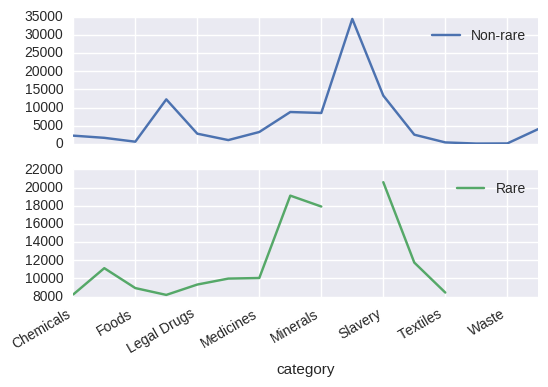

In [126]:
cat_rare_avg.plot(x='category', subplots=True)

#### What ten commodities have the highest profit margin? (Where profit margin is defined as the difference between maximum buy price and minimum sell price.)

In [144]:
max_buy = price_data.groupby('commodity_id')[['buy_price']].max()
min_sell = price_data.groupby('commodity_id')[['sell_price']].min()
com_margin = com_data
com_margin['max_buy'] = max_buy['buy_price']
com_margin['min_sell'] = min_sell['sell_price']
com_margin = com_margin.fillna('NaN').query("max_buy != 'NaN' | min_sell != 'NaN'")

In [145]:
def calc_margin(buy, sell):
    return buy - sell

def margin_wrapper(row):
    return calc_margin(row.max_buy, row.min_sell)

In [146]:
com_margin['profit_margin'] = com_margin.apply(margin_wrapper, axis=1)
com_margin.sort_values('profit_margin', ascending=False).head(10)

,average_price,category,category_id,commodity_id,is_rare,name,max_buy,min_sell,profit_margin
114,343,Consumer Items,2,116,0,Evacuation Shelter,115801,77828,37973.0
59,10584,Slavery,10,60,0,Slaves,17057,1703,15354.0
45,19279,Metals,8,46,0,Platinum,14852,11272,3580.0
306,332,Salvage,16,309,0,Galactic Travel Guide,5362,2121,3241.0
81,40508,Minerals,9,83,0,Painite,8563,5554,3009.0
42,5727,Metals,8,43,0,Indium,10517,7744,2773.0
69,1856,Technology,11,70,0,Robotics,6485,4726,1759.0
24,357,Machinery,6,25,0,Atmospheric Processors,7165,5459,1706.0
38,647,Metals,8,39,0,Cobalt,8613,6940,1673.0
109,8766,Metals,8,111,0,Lanthanum,12080,10419,1661.0
